# Проект "Анализ удовлетворённости работой и прогнозирование оттока сотрудников"

**Заказчик:** компания «Работа с заботой» (далее - Компания).

**Цели проекта:** 
- Построить модель машинного обучения для предсказания уровня удовлетворённости сотрудников Компании (метрика SMAPE <=15).
- Построить модель машинного обучения для предсказания уволится ли сотрудник из Компании (метрика ROC-AUC >=0.91).
- Выделить ключевые признаки, влияющие на удовлетворённость и увольнение и выдать рекомендации заказчику.

## 0. Подготовка ноутбука к работе

In [92]:
pip install -q phik

Note: you may need to restart the kernel to use updated packages.


In [93]:
pip install -q shap

Note: you may need to restart the kernel to use updated packages.


In [94]:
# Disable warnings
import warnings
warnings.filterwarnings("ignore")

In [95]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Statistical analysis
from scipy.stats import ttest_ind, f_oneway

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection and evaluation
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Data preprocessing
from sklearn.preprocessing import(OneHotEncoder,
                                  OrdinalEncoder,
                                  LabelEncoder,
                                  StandardScaler,
                                  MinMaxScaler)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Machine learning models
from sklearn.linear_model import (Lasso,
                                  LogisticRegression)
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyRegressor, DummyClassifier

# Pipeline creation
from sklearn.pipeline import Pipeline

# Model evaluation metrics
from sklearn.metrics import(make_scorer,
                            roc_auc_score)

# Additional tools
from phik import phik_matrix
import shap

In [96]:
# Constants
RANDOM_STATE = 0

In [97]:
# Float numbers visualization format
pd.options.display.float_format = '{:,.2f}'.format

In [98]:
# Function for main info
def main_info (df):
    """
    Displays basic information about the DataFrame.

    Parameters:
    - df: pandas DataFrame

    Returns:
    - None
    """

    print("\nDataFrame Shape:")
    print(f"\nЧисло наблюдений: {df.shape[0]}")
    print(f"\nЧисло признаков: {df.shape[1]}")

    print("\nDataFrame Info:")
    display(df.info())

    print("DataFrame Head:")
    display(df.head())

    print("Number of Missing values:")
    display(df.isna().sum().sort_values(ascending=False))

    print("Percentage of Missing values:")
    display(df.isna().sum()/len(df))

    print("Duplicates:")
    display(df.duplicated().sum())
    return None

In [99]:
# Numeric Values
def numeric(df):
    """
    Identifies numeric columns in a DataFrame.

    Parameters:
    - df: pandas DataFrame

    Returns:
    A list of column names containing numeric data types.
    """
    columns = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]
    return columns

In [100]:
# Categoric Values
def categoric(df):
    """
    Identifies non-numeric columns in a DataFrame.

    Parameters:
    - df: pandas DataFrame

    Returns:
    A list of column names containing non-numeric data types.
    """
    columns = [col for col in df.columns if df[col].dtype == 'object']
    return columns

In [101]:
# Density Plot & Box Plot 
def plot_density_and_boxplot(data, column):
    """
    Plot density plot and boxplot for a given column in a DataFrame.

    Parameters:
    - df: pandas DataFrame
    - column: str

    Returns:
    - None
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot density plot
    sns.histplot(data[column], bins=50, color='lightgreen', kde=True, ax=axs[0])
    axs[0].set_title(f'Density Plot of {column}')

    # Plot boxplot
    axs[1].boxplot(data[column], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    axs[1].set_title(f'Boxplot of {column}')

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

In [102]:
# Pie Chart for categoric features
def plot_pie_chart(df, column):
    """
    Plot a pie chart to visualize the distribution of categorical data in the specified column of the DataFrame.

    Parameters:
    - df: pandas DataFrame
    - column: str

    Returns:
    - None
    """
    # Group by the specified column and calculate counts and ratios
    data = df.groupby(column)[column].agg(count=('count'))
    data['ratio (%)'] = round(data['count'] / len(df) * 100)

    # Extract labels and sizes
    labels = data.index
    sizes = data['ratio (%)']

    # Plot the pie chart
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f'{column} ratio')
    plt.show()

## 1. Предсказание уровня удовлетворённости сотрудника

In [103]:
# Загрузка данных

# Train Set
employee_info = pd.read_csv('https://train_job_satisfaction_rate.csv', index_col=0)

# Test Set
test_features = pd.read_csv('https://test_features.csv')
test_target = pd.read_csv('https://test_target_job_satisfaction_rate.csv')

### 1.1. Первичный анализ и предобработка

#### 1.1.1 Тренировочная выборка

In [104]:
# Просмотр общей информации по датафрейму
main_info(employee_info)


DataFrame Shape:

Число наблюдений: 4000

Число признаков: 9

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB


None

DataFrame Head:


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


Number of Missing values:


dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Percentage of Missing values:


dept                    0.00
level                   0.00
workload                0.00
employment_years        0.00
last_year_promo         0.00
last_year_violations    0.00
supervisor_evaluation   0.00
salary                  0.00
job_satisfaction_rate   0.00
dtype: float64

Duplicates:


245

In [105]:
# Удаление дубликатов
employee_info = employee_info.drop_duplicates()
employee_info.duplicated().sum()

0

In [106]:
# Проверка уникальных значений
for cat in categoric(employee_info):
    print(cat, employee_info[cat].unique())

dept ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'high' 'low']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


In [107]:
# Корректировка описки
employee_info['level'] = employee_info['level'].replace({'sinior': 'senior'})
employee_info['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

- Датасет содержит 8 признаков (5 категориальных, как с ранжированием, так и без ранжирования и 3 количественных), а также таргет.
- Типы данных указаны корректно.
- Присутствуют пропуски в признаках "dept", "level", составляют менее 1%. Необходимо учесть при подготовке данных для модели (заполнить модой при кодировании).
- Дубликаты удалены.
- Исправлена описка в признаке "level".

#### 1.1.2 Тестовая выборка

In [108]:
# Проверка на соответствие числа строк датасетов с признаками и таргетом
assert test_features.shape[0] == test_target.shape[0], 'Число строк с признаками и таргетом не совпадает!'

In [109]:
# Общая информация по признакам
main_info(test_features)


DataFrame Shape:

Число наблюдений: 2000

Число признаков: 9

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

DataFrame Head:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Number of Missing values:


dept                     2
level                    1
id                       0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Percentage of Missing values:


id                      0.00
dept                    0.00
level                   0.00
workload                0.00
employment_years        0.00
last_year_promo         0.00
last_year_violations    0.00
supervisor_evaluation   0.00
salary                  0.00
dtype: float64

Duplicates:


0

In [110]:
# Общая информация по таргету
main_info(test_target)


DataFrame Shape:

Число наблюдений: 2000

Число признаков: 2

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

DataFrame Head:


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Number of Missing values:


id                       0
job_satisfaction_rate    0
dtype: int64

Percentage of Missing values:


id                      0.00
job_satisfaction_rate   0.00
dtype: float64

Duplicates:


0

In [111]:
# Объединение по ID, чтобы таргет шёл в том же порядке, что и признаки
test_set = test_features.merge(test_target, on='id')
test_set.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


In [112]:
# Проверка на дубликаты
test_set.duplicated().sum()

0

In [113]:
# Проверка уникальных значений 
for cat in categoric(test_set):
    print(cat, test_set[cat].unique())

dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' ' ']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


In [114]:
# Корректировка
test_set['level'] = test_set['level'].replace({'sinior': 'senior'})
test_set['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [115]:
# Замена пробелов на NaN
test_set.replace(' ', np.nan, inplace=True)

In [116]:
# Итоговая тестовая выборка
test_set = test_set.set_index('id')
test_set.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79
686555,hr,junior,medium,1,no,no,4,30000,0.72
467458,sales,middle,low,5,no,no,4,19200,0.64
418655,sales,middle,low,6,no,no,4,19200,0.60
789145,hr,middle,medium,5,no,no,5,40800,0.75


Признаки
- Присутствуют пропуски в признаках "dept", "level", составляют менее 1%. Необходимо учесть при подготовке данных для модели (заполнить модой при кодировании).
- Устранены пробелы в признаках 'dept', 'workload'.
- Полных дубликатов нет, дубликатов в первичном ключе нет.
- Исправлена описка в "level".

Таргет
-  Пропусков нет, дубликатов нет.

Количество наблюдений в признаках и таргрете совпадает.

### 1.2. EDA

In [117]:
# Статистические показатели числовых признаков тренировочной выборки
employee_info[numeric(employee_info)].describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,"3,755.00","3,755.00","3,755.00","3,755.00"
mean,3.82,3.46,"34,457.42",0.53
std,2.56,1.03,"15,050.64",0.23
min,1.00,1.00,"12,000.00",0.03
25%,2.00,3.00,"22,800.00",0.35
50%,3.00,4.00,"31,200.00",0.55
75%,6.00,4.00,"44,400.00",0.71
max,10.00,5.00,"98,400.00",1.00


- Средний стаж работы составляет 3.72 года, что указывает на то, что большинство сотрудников проработало в компании относительно короткий срок. Медиана меньше и равна 3 годам.
- Стандартное отклонение (2.54 года) указывает на умеренный разброс значений вокруг среднего значения. Разброс от 1 до 10 лет показывает, что есть значительное разнообразие в стаже работы сотрудников.
- Средняя оценка от руководителя составляет 3.48, что указывает на в целом положительные, но не очень высокие оценки.
- Средняя зарплата составляет 33,953.38. 
- Стандартное отклонение (14,907.25) показывает, что зарплаты варьируются довольно сильно. Разброс от 12,000 до 98,400 указывает на широкий диапазон зарплат среди сотрудников.
- Средний уровень удовлетворенности составляет 0.53.
- Стандартное отклонение (0.23) показывает, что есть умеренный разброс в уровне удовлетворенности.

- Необходимо сравнить с тестовой выборкой.

In [118]:
# Статистические показатели числовых признаков тестовой выборки
test_set[numeric(test_set)].describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,"2,000.00","2,000.00","2,000.00","2,000.00"
mean,3.67,3.53,"34,066.80",0.55
std,2.54,1.00,"15,398.44",0.22
min,1.00,1.00,"12,000.00",0.03
25%,1.00,3.00,"22,800.00",0.38
50%,3.00,4.00,"30,000.00",0.58
75%,6.00,4.00,"43,200.00",0.72
max,10.00,5.00,"96,000.00",1.00


- Отмечается, что данные в тестовой выборке распределены аналогично тренировочной выборке.
- Аномалий не прослеживается.

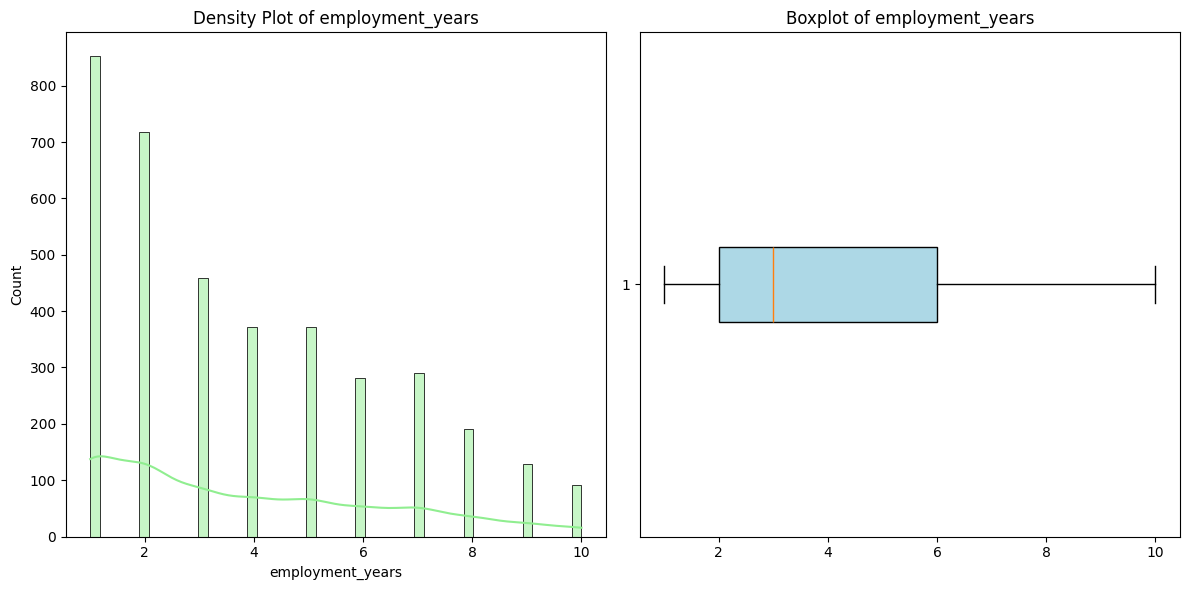

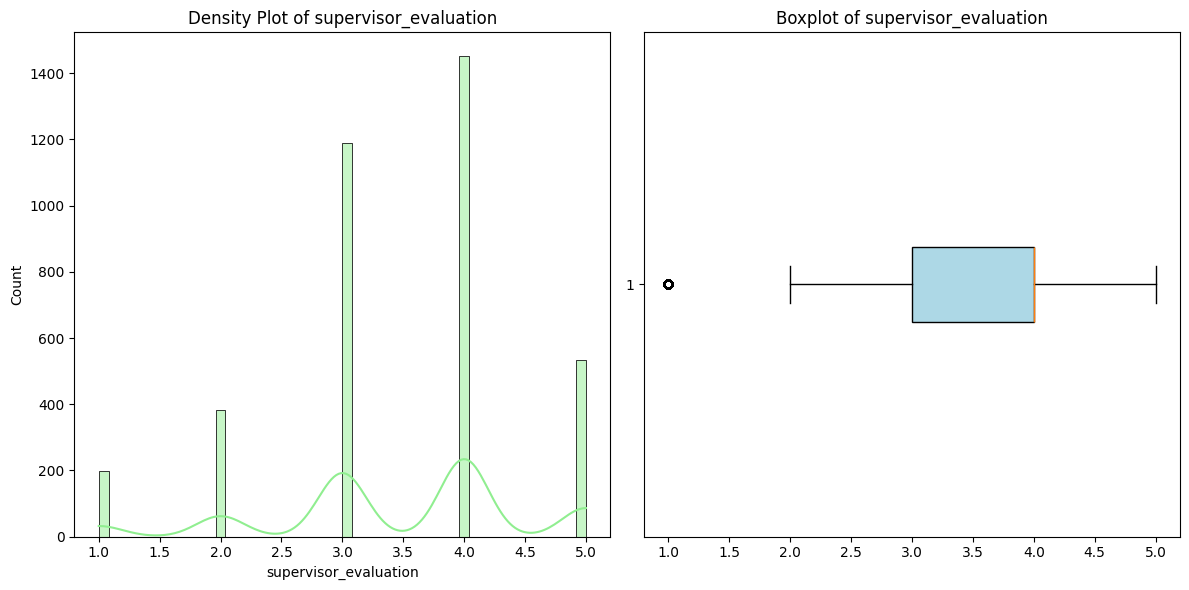

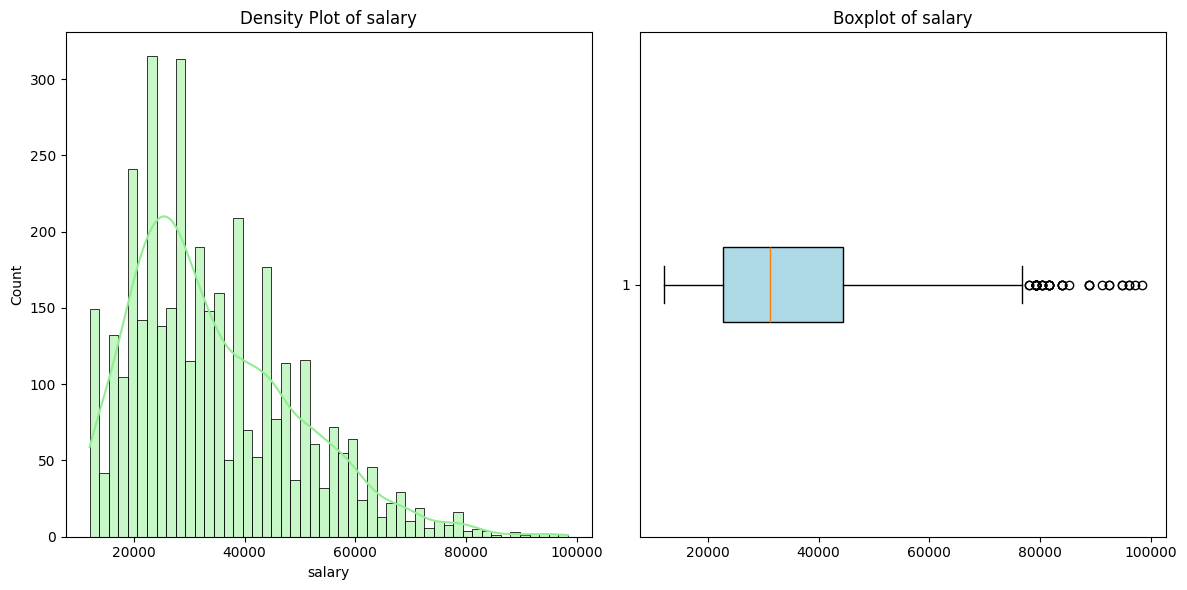

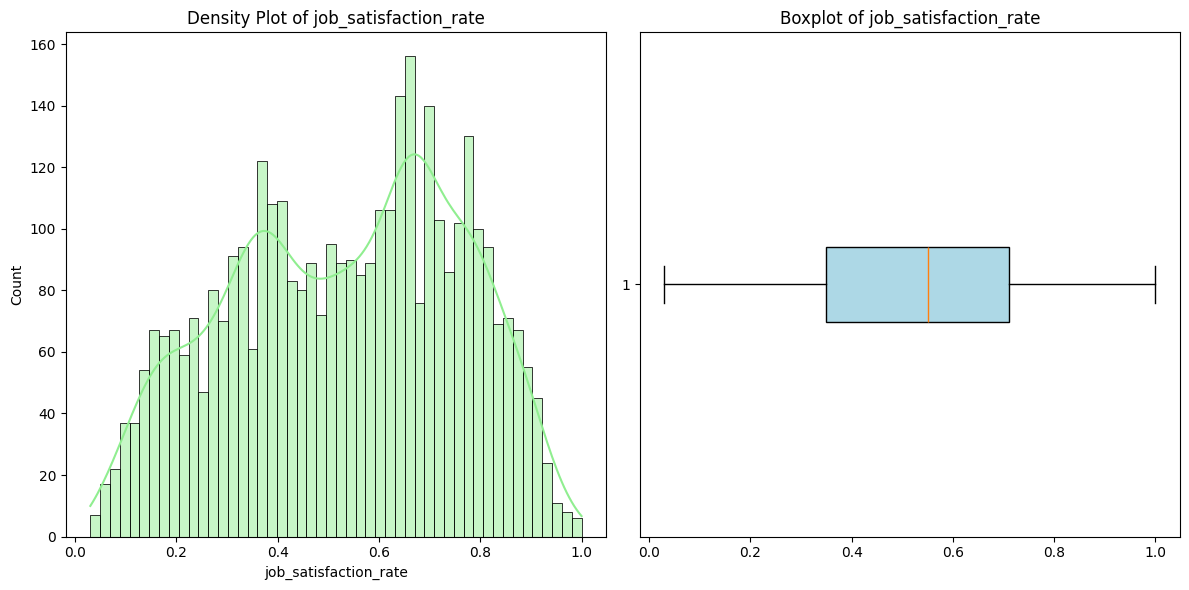

In [119]:
# Оценка распределений количественных признаков и таргета в тренировочной выборке
for col in employee_info[numeric(employee_info)]:
    plot_density_and_boxplot(employee_info, col)

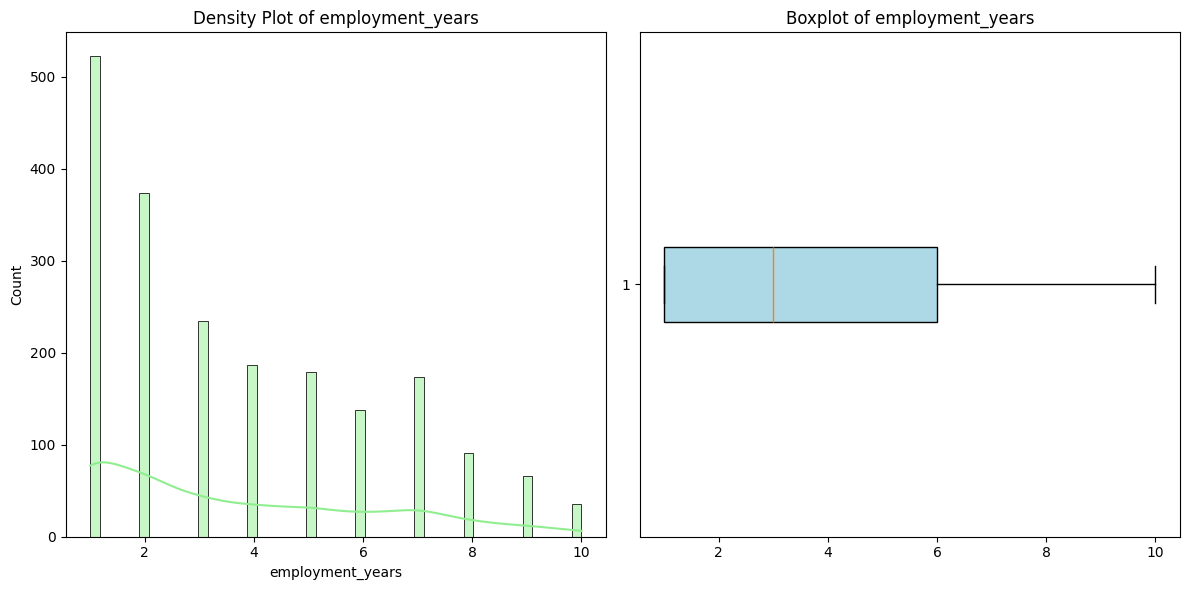

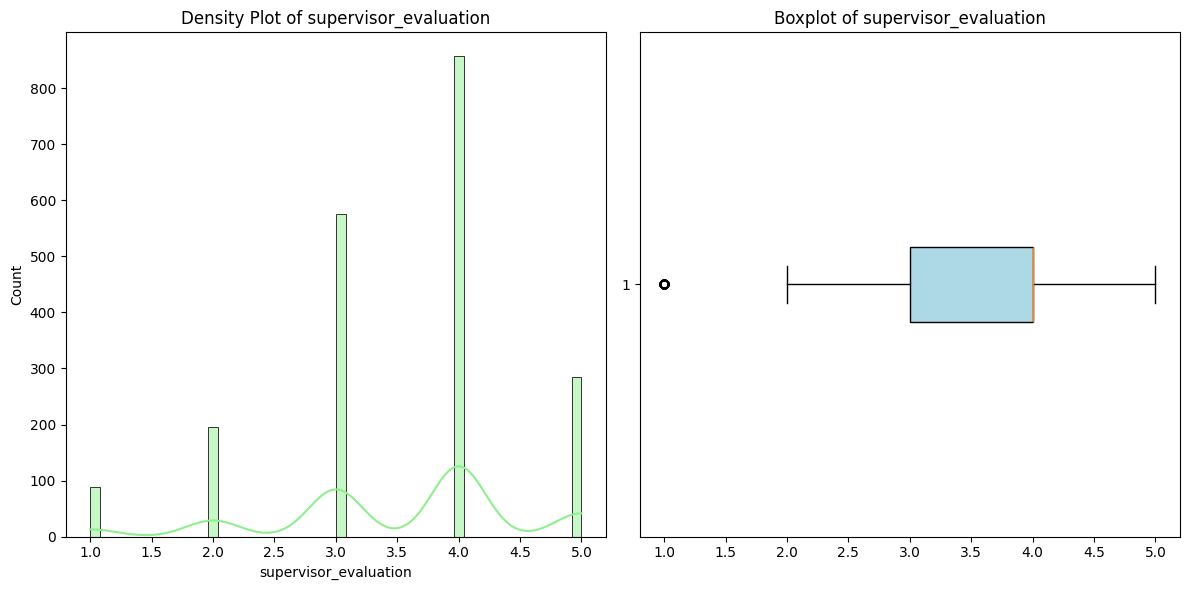

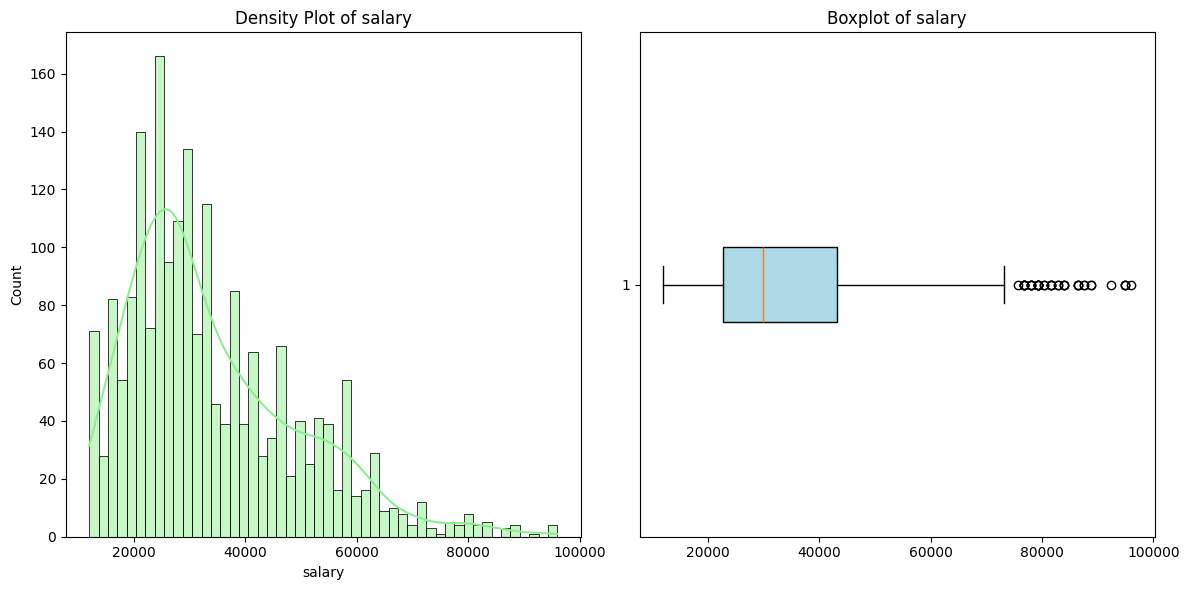

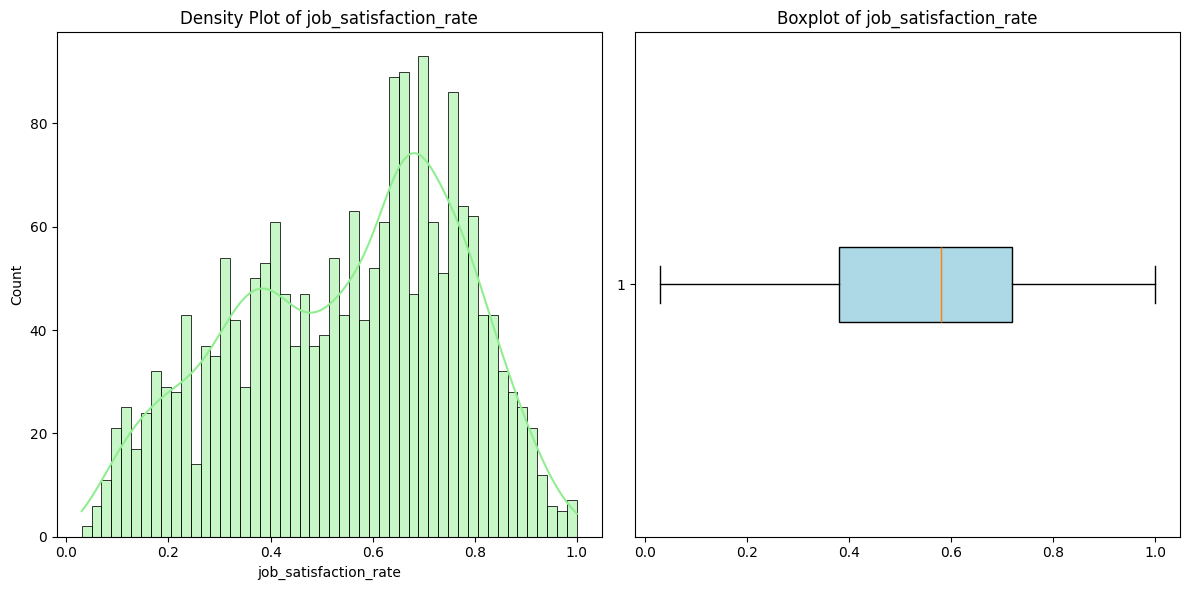

In [120]:
# Оценка распределений количественных признаков и таргета в тестовой выборке
for col in test_set[numeric(test_set)]:
    plot_density_and_boxplot(test_set, col)

- Распределение зарплаты не нормальные и не симметричные.
- Боксплоты показывают выбросы, однако, нельзя утверждать, что такие значения являются аномальными.
- Распределение таргета бимодальное - имеет пики в райноне 0.4 и 0.7.

- **Распределения признаков в тестовой выборке идентичны тренировочной. Однако, вид, который прияли гистограммы стажа и оценки указывают на то, что данные признаки имеют категориальный характер. Необходимо изучить барплоты.**

In [121]:
# Уникальные значения стажа
employee_info['employment_years'].unique()

array([ 2,  1,  4,  7,  9,  6,  3, 10,  8,  5])

In [122]:
# Уникальные значения оценки
employee_info['supervisor_evaluation'].unique()

array([1, 5, 2, 3, 4])

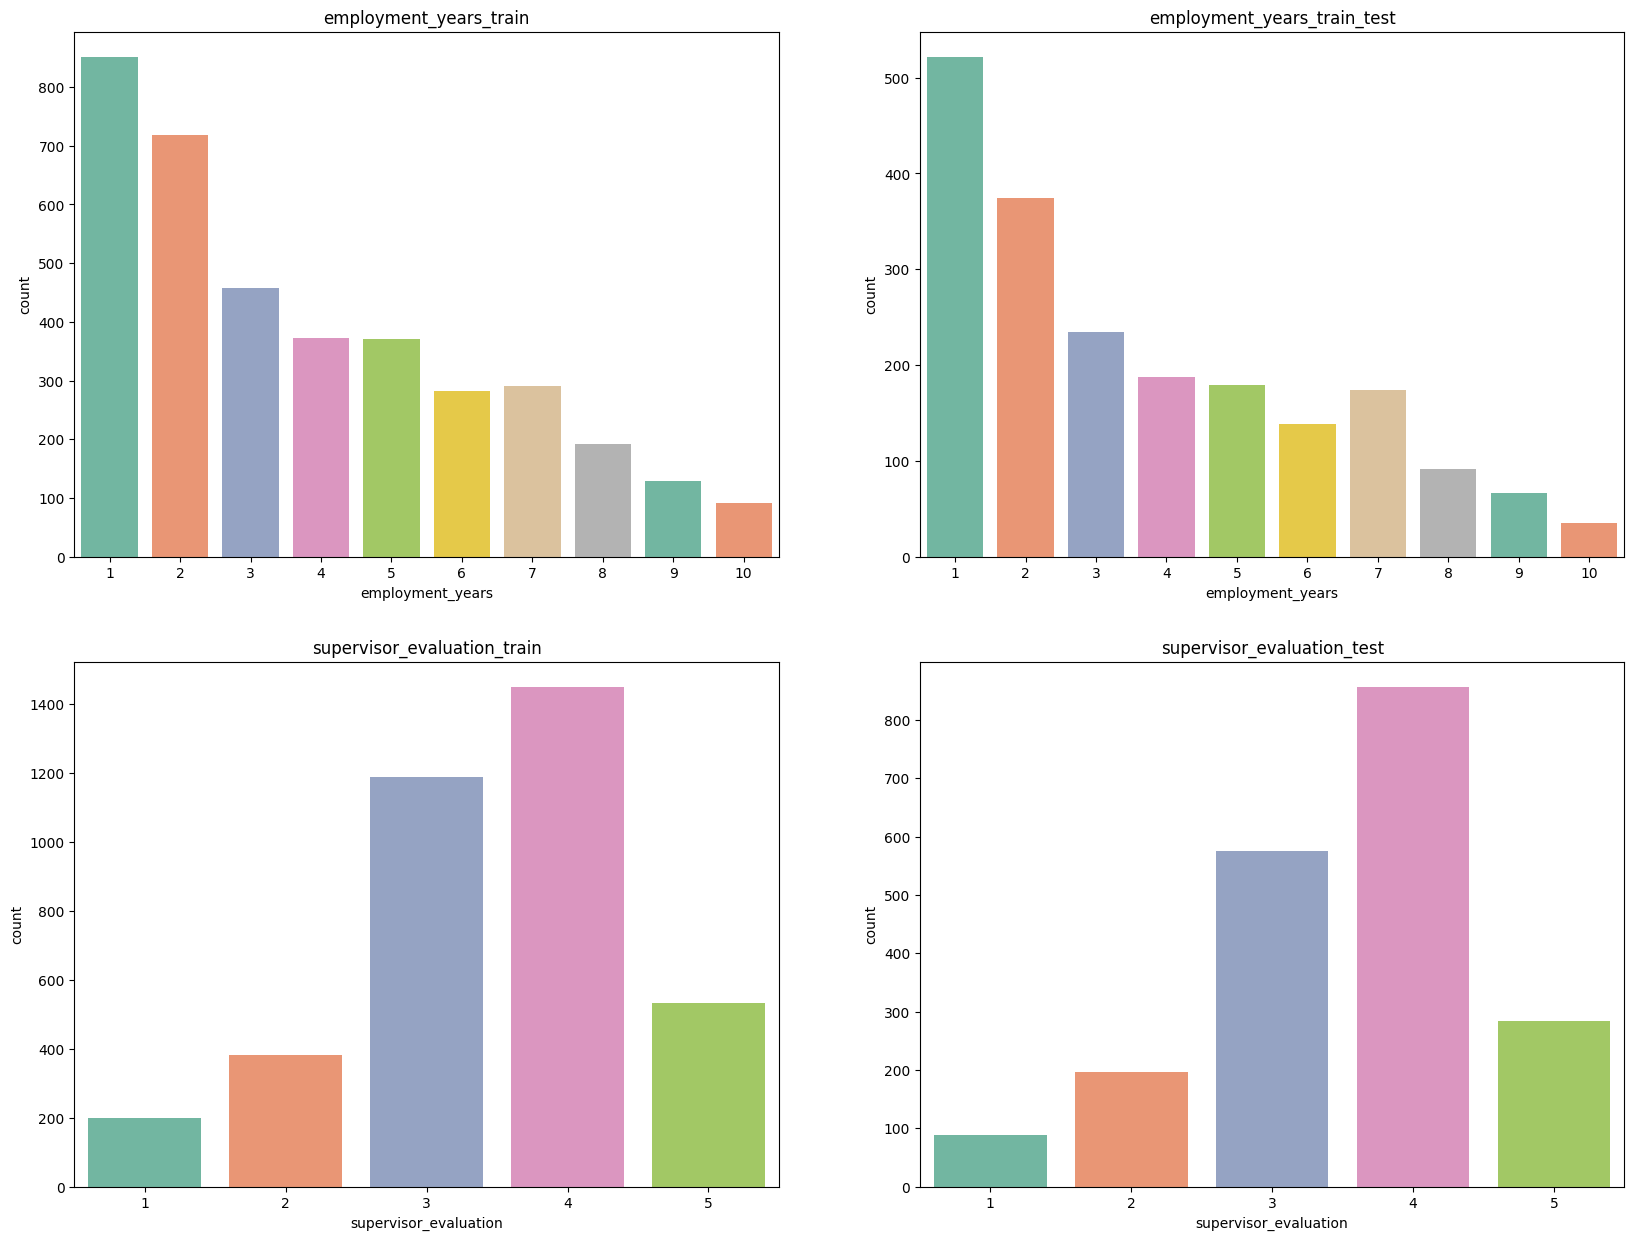

In [123]:
# Визуализация дискретных признаков
fig, axes = plt.subplots(2, 2, figsize=(20,15))
sns.countplot(x ='employment_years', data = employee_info, 
              palette = "Set2", ax=axes[0,0]).set(title='employment_years_train');
sns.countplot(x ='employment_years', data = test_set, 
              palette = "Set2", ax=axes[0,1]).set(title='employment_years_train_test');
sns.countplot(x ='supervisor_evaluation', data = employee_info, 
              palette = "Set2", ax=axes[1,0]).set(title='supervisor_evaluation_train');
sns.countplot(x ='supervisor_evaluation', data = test_set, 
              palette = "Set2", ax=axes[1,1]).set(title='supervisor_evaluation_test');

- Большинство сотрудников Компании работают в компании один год. 
- При этом с увеличением стажа, количество сотрудников снижается.
- В оценках сотрудников преобладают оценки 3 и 4.

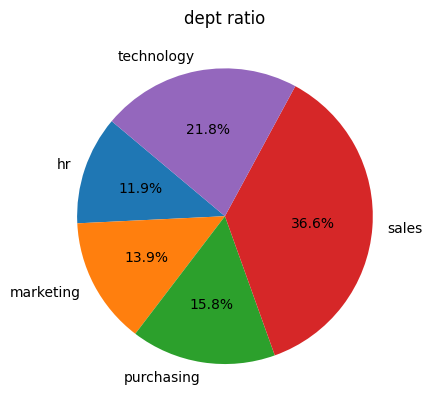

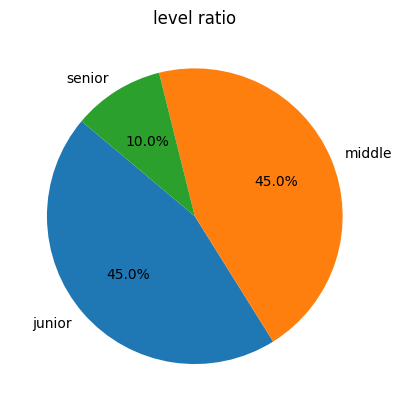

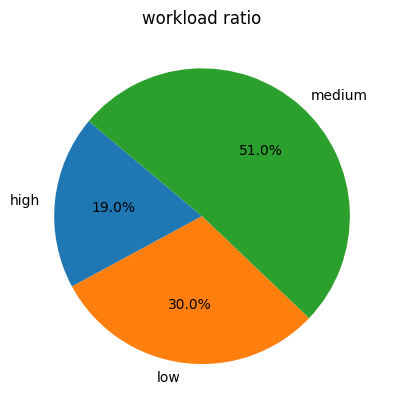

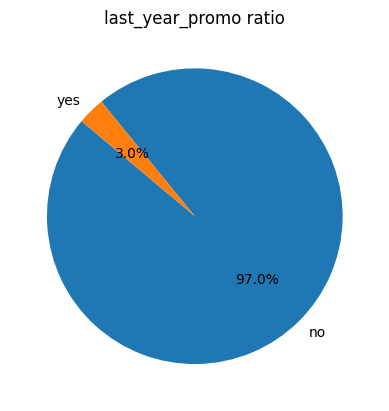

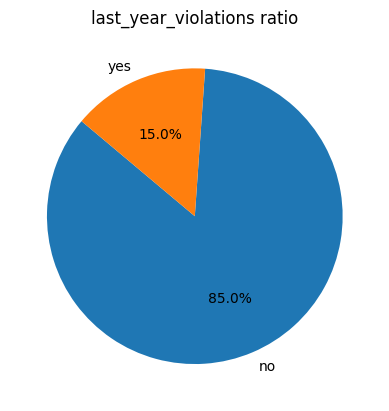

In [124]:
# Визуализация категориальных признаков тренировочной выборки
for cat in employee_info[categoric(employee_info)]:
    plot_pie_chart(employee_info, cat)

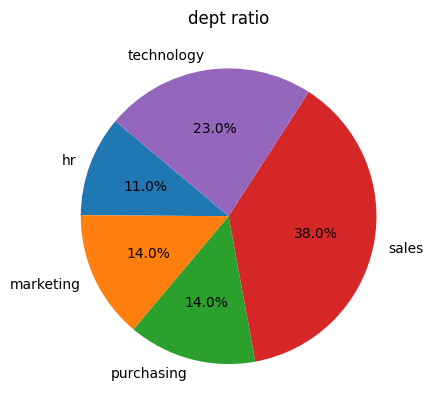

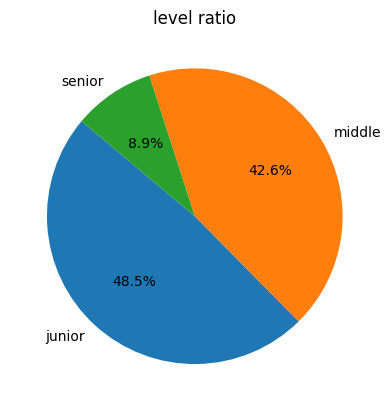

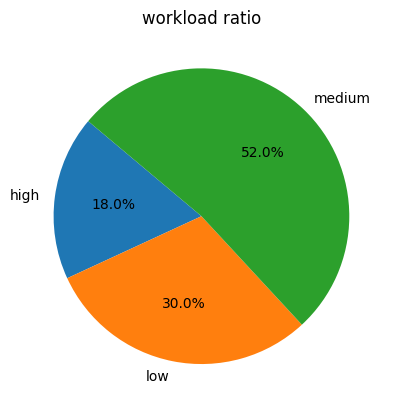

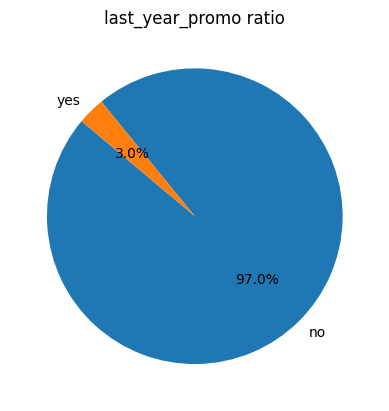

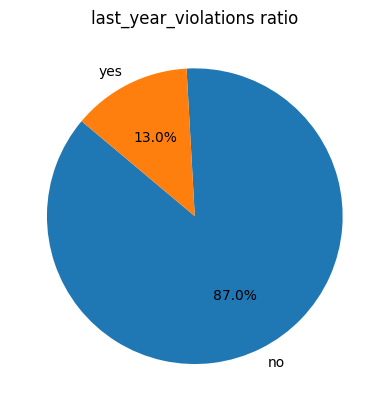

In [125]:
# Визуализация категориальных признаков тестовой выборки
for cat in test_set[categoric(test_set)]:
    plot_pie_chart(test_set, cat)

Присутствуют категориальные признаки двух типов:
- Без ранжирования (отдел, было ли повышение, нарушал ли договор).
- С Ранжированием (уровень должности, уровень загруженности).
- Соотношения категориальных признаков в тренировочной и тестовой выборках совпадают.

In [126]:
numeric(employee_info)

['employment_years',
 'supervisor_evaluation',
 'salary',
 'job_satisfaction_rate']

In [127]:
# Матрица корреляции
matrix = phik_matrix(employee_info, interval_cols=['salary','job_satisfaction_rate'])

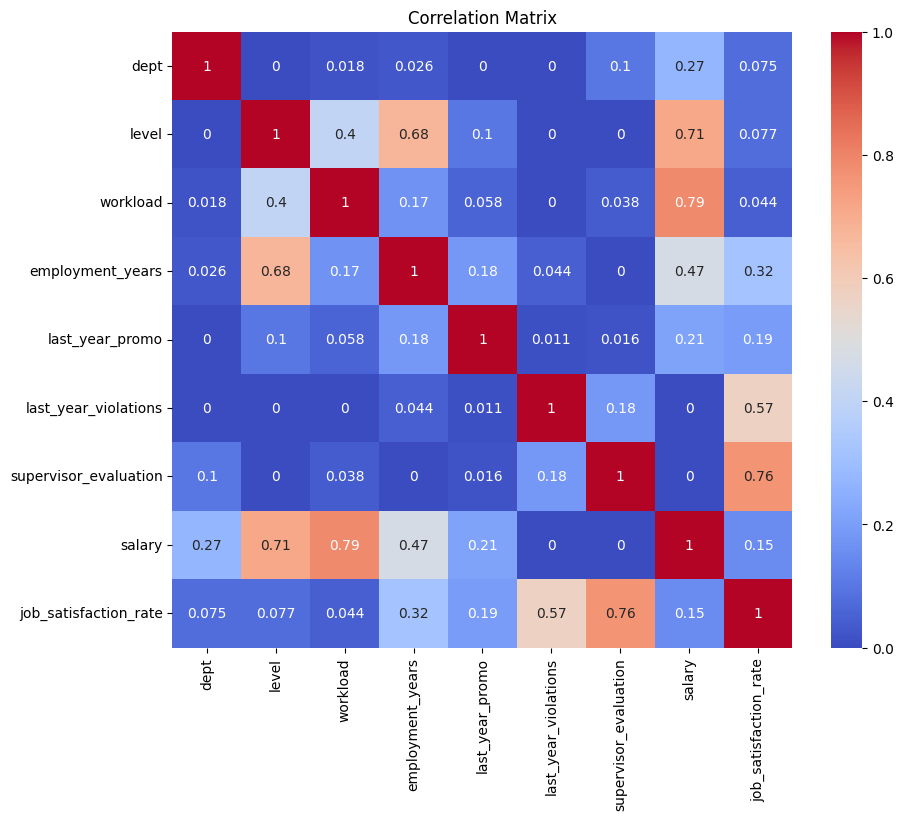

In [128]:
plt.figure(figsize=[10,8])
sns.heatmap(matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

- Отмечается высокая корреляция таргета с оценкой супервайзера, средняя с нарушениями, низкая со стажем и крайне низкая с отделом, уровнем, объёмом работы, было ли повышение, зарплатой.
- Мультиколлинеарности признаков не отмечается.

- Признаки отдел, уровень должности, объём работы, было ли повышение, зарплата не показывают значимой корреляции с таргетом. Однако, низкая линейная связь не обязательно означает отсутствие зависимости.

Возможные варианты решения:
- Использование нелинейной моделей (например, дерево решений).
- Использование регуляризации может помочь модели определить важность признаков и уменьшить наличие неинформативных признаков.


### 1.3. Подготовка признаков и моделирование

В качестве моделей используются:
- линейная модель - Lasso (L1-регуляризация),
- дерево решений DecisionTreeRegressor.

In [129]:
# Выборки

X_train = employee_info.drop('job_satisfaction_rate', axis=1)
y_train = employee_info['job_satisfaction_rate']

X_test = test_set.drop('job_satisfaction_rate', axis=1)
y_test = test_set['job_satisfaction_rate']

X_train.shape, X_test.shape

((3755, 8), (2000, 8))

In [130]:
# Списки категориальных и числовых признаков

onehot_features = ['dept', 'last_year_promo', 'last_year_violations']
ordinal_features = ['level', 'workload']
numerical_features = ['employment_years', 'supervisor_evaluation', 'salary']

# Проверка, что все признаки учтены
assert len(onehot_features) + len(ordinal_features) + len(numerical_features) == X_train.shape[1], \
    'Не все признаки учтены.'

In [131]:
# Пайплайн для кодировки признаков без ранжирования

onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

In [132]:
# Пайплайн для подготовки признаков с ранжированием

ordinal_transformer = Pipeline(steps=[
    ('imputer_init', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['junior', 'middle', 'senior'],
                                           ['low', 'medium', 'high']],
                              handle_unknown='use_encoded_value',
                              unknown_value=-1)),
    ('imputer_final', SimpleImputer(missing_values=-1, strategy='most_frequent'))
])

# Пайплайн для подготовки числовых признаков

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Общий папйплайн для подготовки признаков

features_preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', onehot_transformer, onehot_features),
        ('ordinal', ordinal_transformer, ordinal_features),
        ('num', numeric_transformer, numerical_features)
    ],
    remainder='passthrough'
)

# Пайплайн, включающий подготовку данных и модель

satisfaction_pipe = Pipeline(steps=[
    ('preprocessor', features_preprocessor),
    ('model', Lasso(random_state=RANDOM_STATE))
])

In [133]:
#  Функция для расчёта SMAPE
def smape(actual, forecast):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE)
    """
    return 100 / len(actual) * np.sum(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))

smape_score = make_scorer(smape, greater_is_better=False)

In [134]:
# Параметрическая сетка для GridSearchCV

param_grid = [
    {
        'model': [Lasso(random_state=RANDOM_STATE)],
        'model__alpha': [0.1, 1.0, 10.0],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), 'passthrough']
    },
    {
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': range(5, 11),
        'model__max_features': range(2, 11),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), 'passthrough']
    },
]

In [135]:
# Поиск по сетке

grid_search = GridSearchCV(
    satisfaction_pipe,
    param_grid=param_grid,
    scoring=smape_score,
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ordinal',
                                                                         Pipeline(...
                          'model__alpha': [0.1, 1.0, 10.0],
                          'preprocessor__num': [MinMaxScaler(),
                                                StandardScaler(),
                                                'passthrough']},
                         {'model': [DecisionTreeRegressor(random_state=0)],
                          'model__max_depth': range(5, 11),
                          'model__max_features': range(2, 11),
                          'preprocessor__num': [MinMaxScaler(),
                                                StandardScaler(),
                                                'passthrough']}],
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [136]:
# Лучшая модель
grid_search.best_params_

{'model': DecisionTreeRegressor(random_state=0),
 'model__max_depth': 10,
 'model__max_features': 10,
 'preprocessor__num': StandardScaler()}

In [137]:
# SMAPE на кросс-валидации
print(f'Метрика SMAPE на кросс-валидации: {grid_search.best_score_*-1}')

Метрика SMAPE на кросс-валидации: 16.45189088718716


In [138]:
# SMAPE на тестовой выборке
model = grid_search.best_estimator_
y_pred = model.predict(X_test)

smape_test = smape(y_test, y_pred)
print(f'Метрика SMAPE на тестовой выборке: {smape_test}')

Метрика SMAPE на тестовой выборке: 14.947617632255806


- Значение метрики не превышает 15, что соответствует ТЗ.
- Изучим признаки, которые сильнее всего влияют на таргет.

In [139]:
# Проверка модели на адекватность

satisfaction_pipe_dummy = Pipeline(steps=[
    ('preprocessor', features_preprocessor),
    ('model', DummyRegressor())
])

satisfaction_pipe_dummy.fit(X_train, y_train)

y_pred_dummy = satisfaction_pipe_dummy.predict(X_test)
smape_test_dummy = smape(y_test, y_pred_dummy)

print(f'Метрика SMAPE у DummyRegressor (на тестовой выборке): {smape_test_dummy}')

Метрика SMAPE у DummyRegressor (на тестовой выборке): 38.26225790202238


Метрика DummyRegressor хуже метрики лучшей модели на тестовых выборках. Следовательно, лучшая модель подобрана корректно.

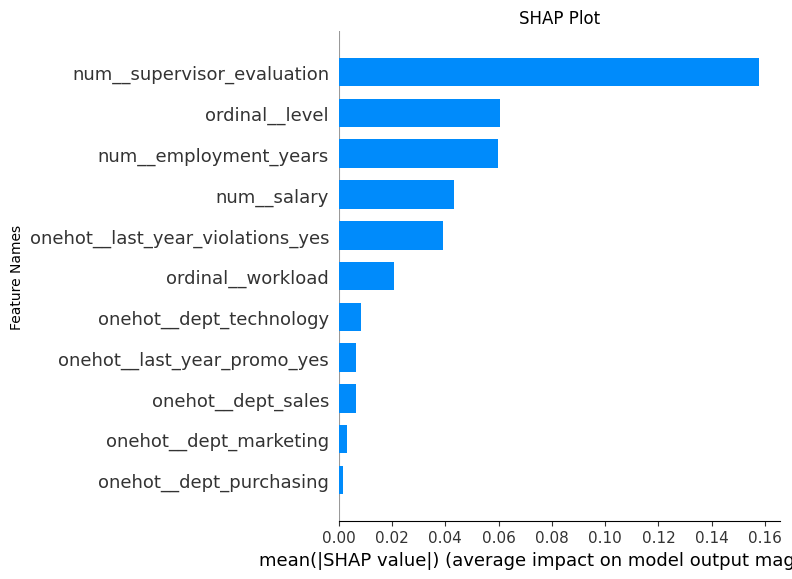

In [140]:
# Визуализация диаграммы SHAP 

fig, ax = plt.gcf(), plt.gca()
ax.set_title("SHAP Plot")
ax.set_ylabel("Feature Names")

# Получение имен признаков после предобработки
feature_names=model.named_steps['preprocessor'].get_feature_names_out()

# Преобразование обучающих данных
x_Train_transformed = model.named_steps['preprocessor'].transform(X_train)

# Создание TreeExplainer для модели
explainer = shap.Explainer(model.named_steps['model'], x_Train_transformed, feature_names=feature_names)

# Вычисление SHAP значений
shap_values = explainer(x_Train_transformed)

# Визуализация SHAP значений с помощью bar plot
shap.summary_plot(shap_values, features=x_Train_transformed, feature_names=feature_names, plot_type="bar")

# Отображение графика
plt.show()

Выводы:
- В качестве моделей были использованы линейная и дерево решений. Однако, изначально признаковое пространство не имеет сильных линейных связей. В ходе вышеприведённого исследования была использована модификация линейной модели Лассо для регуляризации путём обнуления коэффициентов наименее важных признаков. Тем не менее, линейная модель показала себя хуже чем дерево решений. 
- Как результат в качестве лучшей модели выбрана модель DecisionTreeRegressor c глубиной = 10 и максимальным количеством признаков, используемых для поиска наилучшего разделения в каждом узле дерева = 8.
- Модель показала, что на удовлетворённость сильнее всего влияет оценка работы сотрудника и не влияет в каком отделе работает сотрудник.

## 2. Предсказание увольнения сотрудника из компании

In [141]:
# Загрузка данных

train_set = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv', index_col=0)
test_features_2 = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
test_target_2 = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

### 2.1. Первичный анализ и предобработка

#### 2.1.1 Тренировочная выборка

In [142]:
# Общая информация по датафрейму
main_info(train_set)


DataFrame Shape:

Число наблюдений: 4000

Число признаков: 9

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB


None

DataFrame Head:


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


Number of Missing values:


dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

Percentage of Missing values:


dept                    0.00
level                   0.00
workload                0.00
employment_years        0.00
last_year_promo         0.00
last_year_violations    0.00
supervisor_evaluation   0.00
salary                  0.00
quit                    0.00
dtype: float64

Duplicates:


1413

In [143]:
# Удаление дубликатов
train_set = train_set.drop_duplicates()
train_set.duplicated().sum()

0

In [144]:
# Проверка уникальных значений
for cat in categoric(train_set):
    print(cat, train_set[cat].unique())

dept ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level ['middle' 'junior' 'sinior']
workload ['high' 'medium' 'low']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
quit ['no' 'yes']


In [145]:
# Корректировка описки
train_set['level'] = train_set['level'].replace({'sinior': 'senior'})
train_set['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

- Итоговый датасет содержит 9 признаков (5 категориальных, как с ранжированием, так и без ранжирования и 4 количественных), а также таргет 'quit'.
- Типы данных указаны корректно.
- Пропусков в данных нет.
- Дубликаты удалены.
- Исправлена описка в признаке "level".

#### 2.1.2 Тестовая выборка

In [146]:
# Проверка на соответствие числа строк датасетов с признаками и таргетом
assert test_features_2.shape[0] == test_target_2.shape[0], 'Число строк с признаками и таргетом не совпадает!'

In [147]:
# Общая информация по признакам
main_info(test_features_2)


DataFrame Shape:

Число наблюдений: 2000

Число признаков: 9

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

DataFrame Head:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Number of Missing values:


dept                     2
level                    1
id                       0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Percentage of Missing values:


id                      0.00
dept                    0.00
level                   0.00
workload                0.00
employment_years        0.00
last_year_promo         0.00
last_year_violations    0.00
supervisor_evaluation   0.00
salary                  0.00
dtype: float64

Duplicates:


0

In [148]:
# Проверка уникальных значений 
for cat in categoric(test_features_2):
    print(cat, test_features_2[cat].unique())

dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' ' ']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


In [149]:
# Корректировка
test_features_2['level'] = test_features_2['level'].replace({'sinior': 'senior'})
test_features_2['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [150]:
# Замена пробелов на NaN
test_features_2.replace(' ', np.nan, inplace=True)

In [151]:
# Общая информация по таргету
main_info(test_target_2)


DataFrame Shape:

Число наблюдений: 2000

Число признаков: 2

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

DataFrame Head:


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Number of Missing values:


id      0
quit    0
dtype: int64

Percentage of Missing values:


id     0.00
quit   0.00
dtype: float64

Duplicates:


0

In [152]:
# Объединение по ID, чтобы таргет шёл в том же порядке, что и признаки
test_set_2 = test_features_2.merge(test_target_2, on='id')
test_set_2.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,no
1,686555,hr,junior,medium,1,no,no,4,30000,no
2,467458,sales,middle,low,5,no,no,4,19200,no
3,418655,sales,middle,low,6,no,no,4,19200,no
4,789145,hr,middle,medium,5,no,no,5,40800,no


In [153]:
# Проверка на дубликаты
test_set_2.duplicated().sum()

0

In [154]:
test_set_2 = test_set_2.set_index('id')
test_set_2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,no
686555,hr,junior,medium,1,no,no,4,30000,no
467458,sales,middle,low,5,no,no,4,19200,no
418655,sales,middle,low,6,no,no,4,19200,no
789145,hr,middle,medium,5,no,no,5,40800,no


Признаки
- Присутствуют пропуски в признаках "dept", "level", составляют менее 1%. Необходимо учесть при подготовке данных для модели (заполнить модой при кодировании).
- Устранены пробелы в признаках 'dept', 'workload'.
- Полных дубликатов нет.
- Исправлена описка в "level".
- Добавлен новый признак "job_satisfaction_rate"

Таргет
-  Пропусков нет, дубликатов нет.



### 2.2 EDA

#### 2.2.1 Статитстический анализ

In [155]:
# Статистические показатели тренировочной выборки
train_set[numeric(train_set)].describe()

,employment_years,supervisor_evaluation,salary
count,"2,587.00","2,587.00","2,587.00"
mean,4.21,3.37,"37,107.69"
std,2.60,1.08,"16,267.35"
min,1.00,1.00,"12,000.00"
25%,2.00,3.00,"24,000.00"
50%,4.00,3.00,"33,600.00"
75%,6.00,4.00,"46,800.00"
max,10.00,5.00,"96,000.00"


In [156]:
# Статистические показатели тестовой выборки
test_set_2[numeric(test_set_2)].describe()

,employment_years,supervisor_evaluation,salary
count,"2,000.00","2,000.00","2,000.00"
mean,3.67,3.53,"34,066.80"
std,2.54,1.00,"15,398.44"
min,1.00,1.00,"12,000.00"
25%,1.00,3.00,"22,800.00"
50%,3.00,4.00,"30,000.00"
75%,6.00,4.00,"43,200.00"
max,10.00,5.00,"96,000.00"


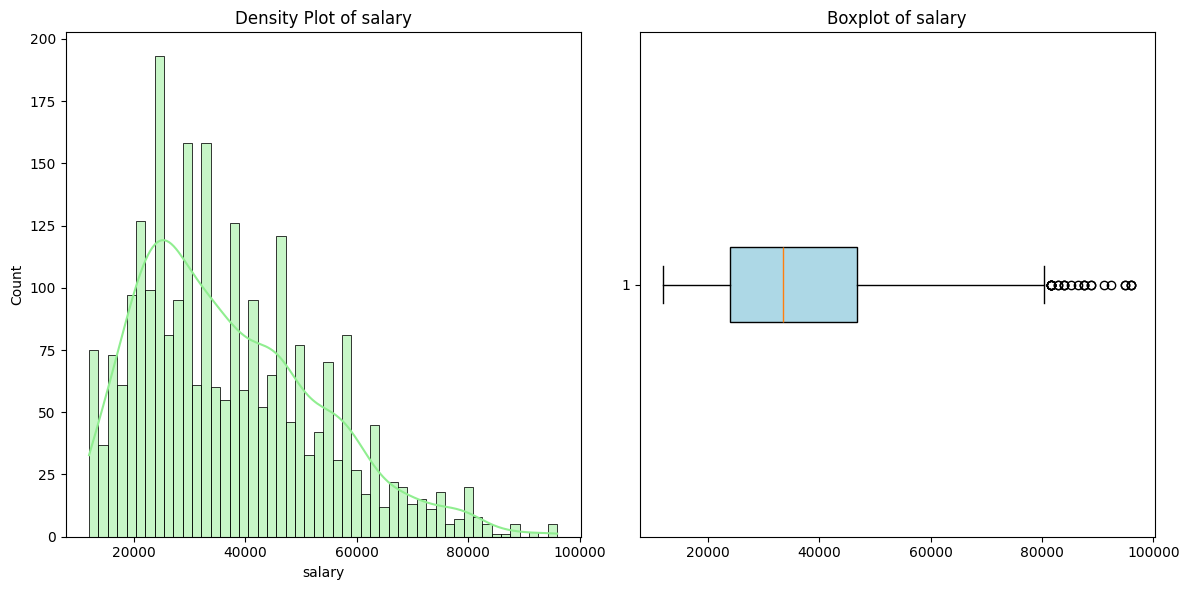

In [157]:
# Оценка распределений количественных признаков тренировочной выборки
plot_density_and_boxplot(train_set, 'salary')

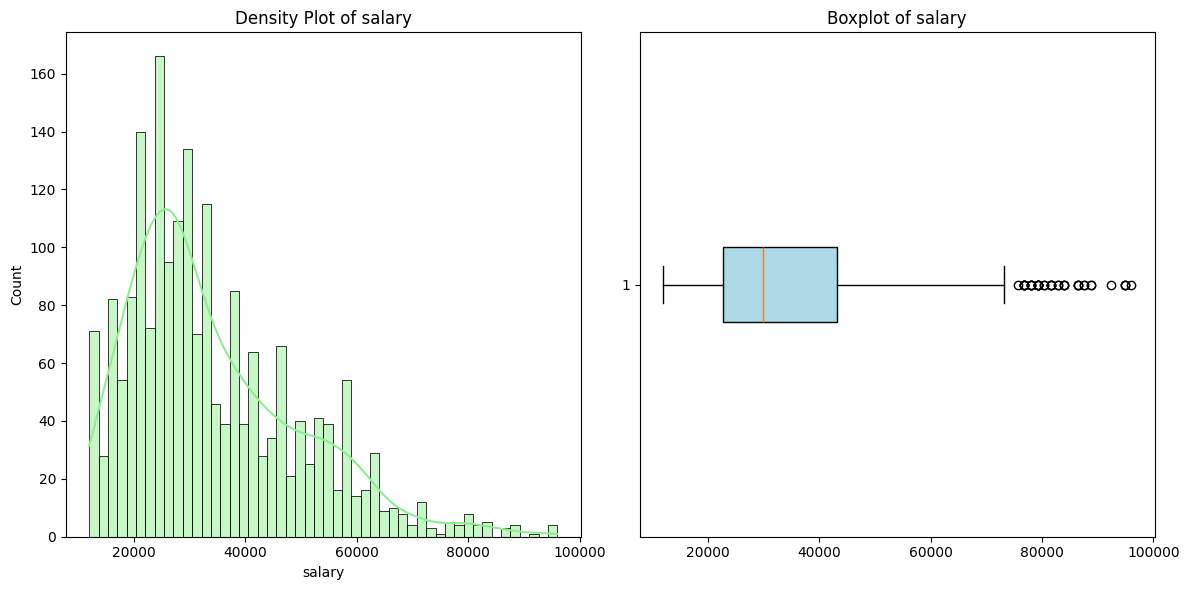

In [158]:
# Оценка распределений количественных признаков тестовой выборки
plot_density_and_boxplot(test_set_2, 'salary')

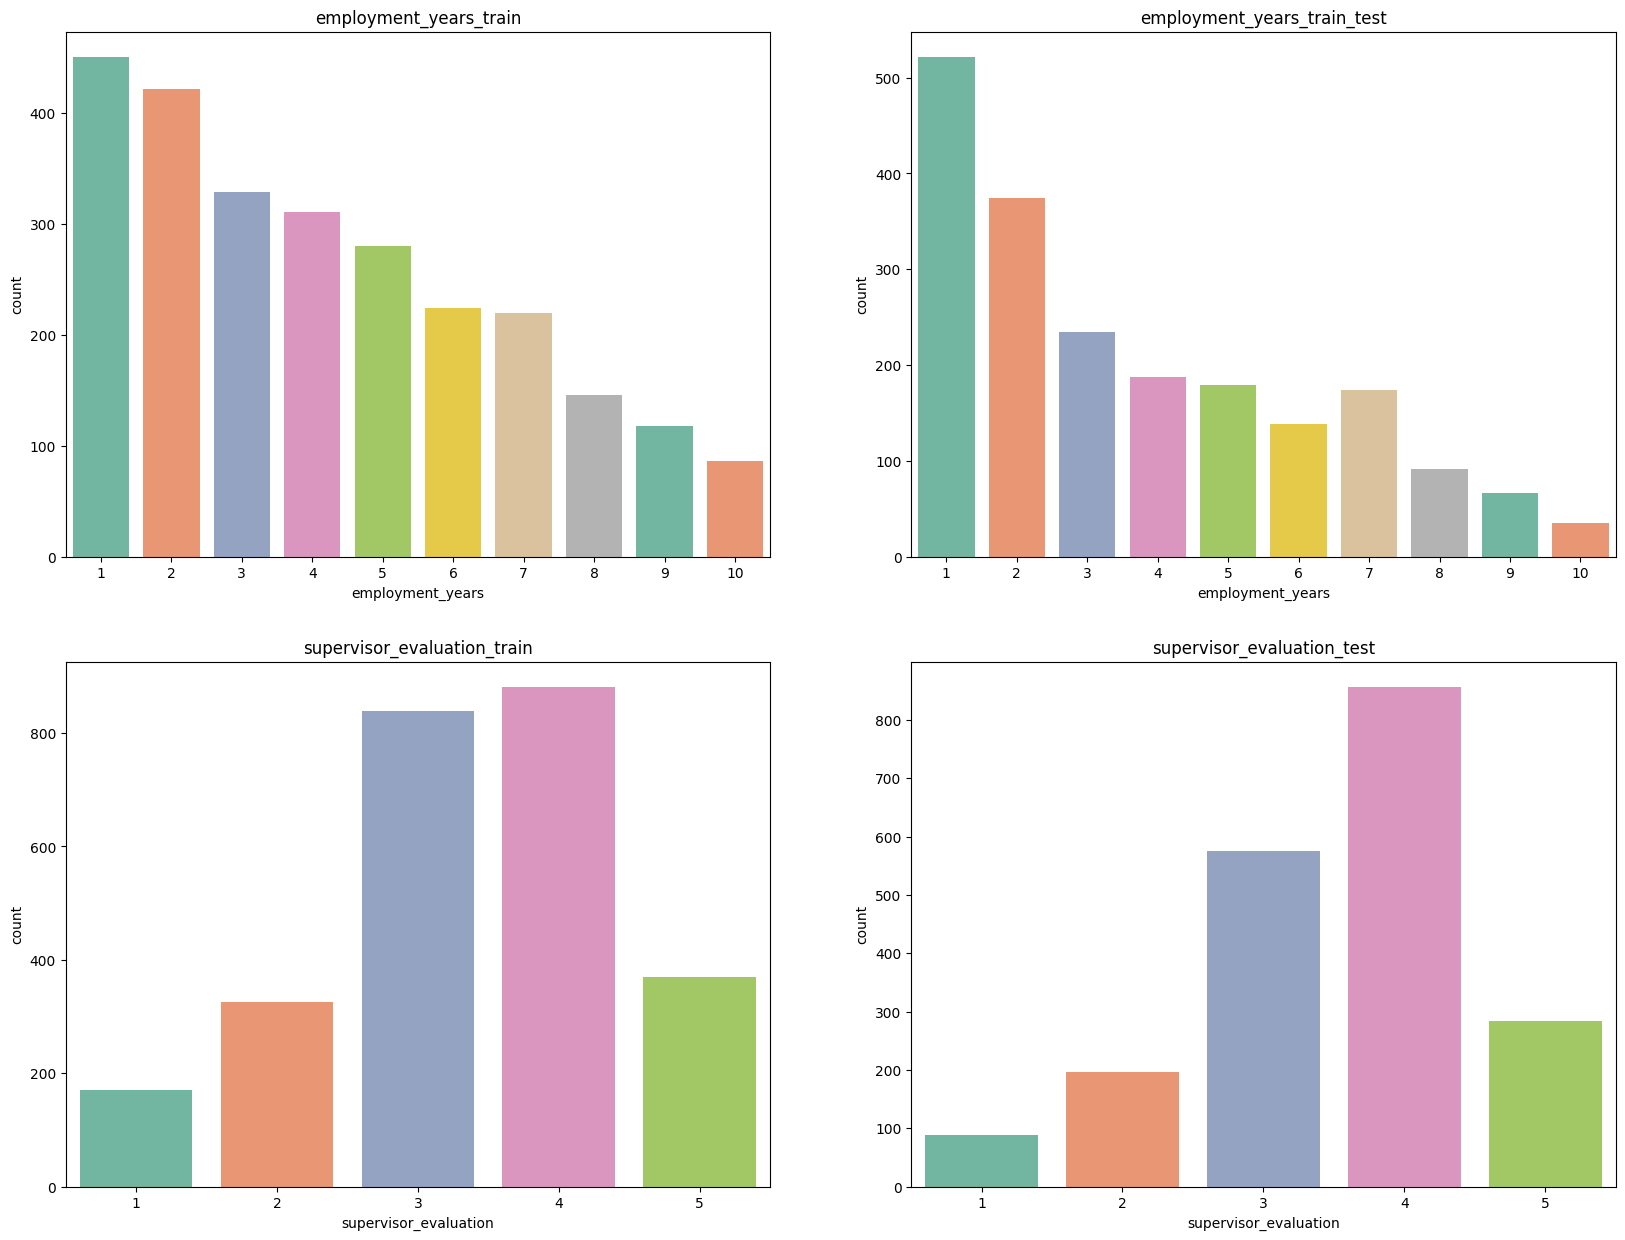

In [159]:
# Визуализация дискретных признаков
fig, axes = plt.subplots(2, 2, figsize=(20,15))
sns.countplot(x ='employment_years', data = train_set, 
              palette = "Set2", ax=axes[0,0]).set(title='employment_years_train');
sns.countplot(x ='employment_years', data = test_set_2, 
              palette = "Set2", ax=axes[0,1]).set(title='employment_years_train_test');
sns.countplot(x ='supervisor_evaluation', data = train_set, 
              palette = "Set2", ax=axes[1,0]).set(title='supervisor_evaluation_train');
sns.countplot(x ='supervisor_evaluation', data = test_set_2, 
              palette = "Set2", ax=axes[1,1]).set(title='supervisor_evaluation_test');

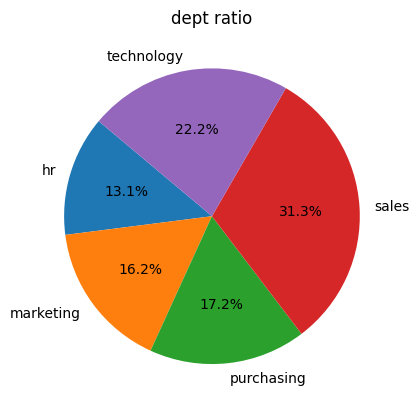

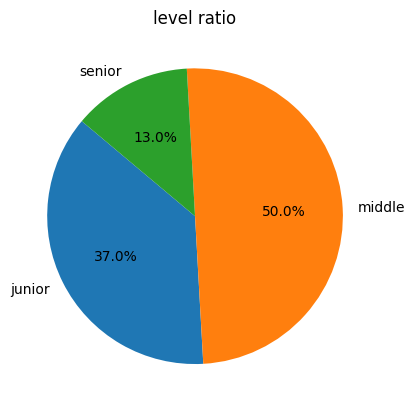

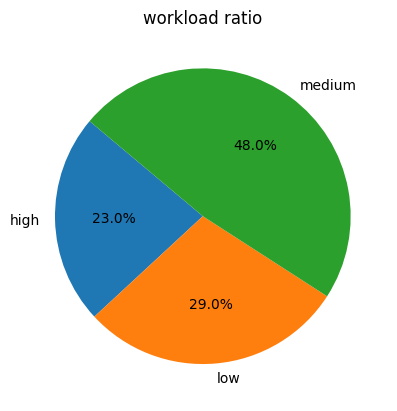

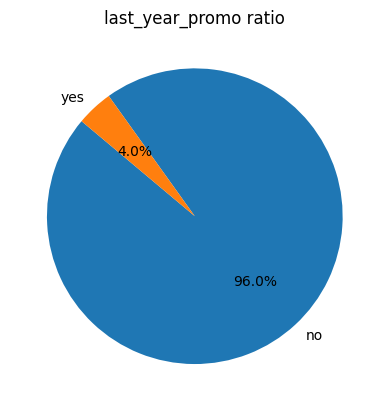

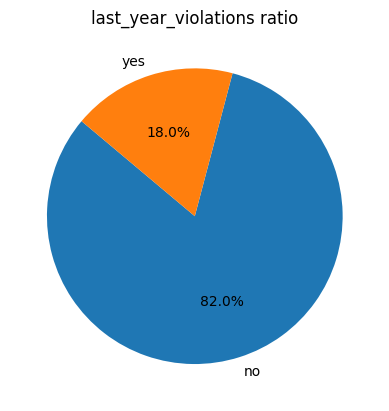

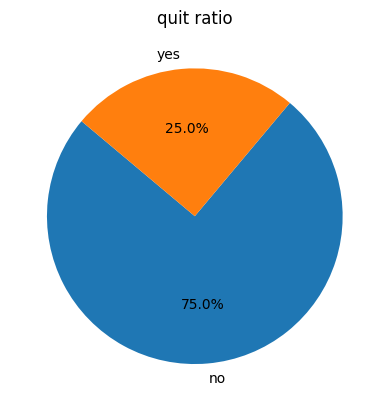

In [160]:
# Визуализация категориальных признаков и таргета тренировочной выборки
for cat in train_set[categoric(train_set)]:
    plot_pie_chart(train_set, cat)

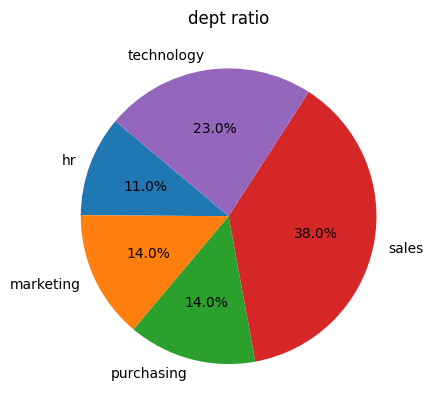

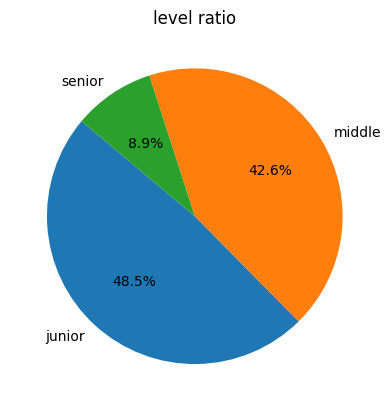

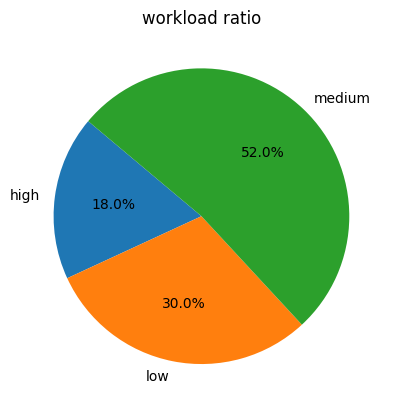

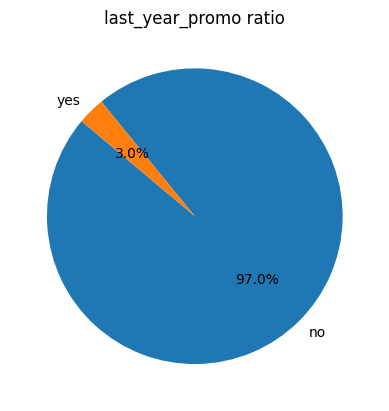

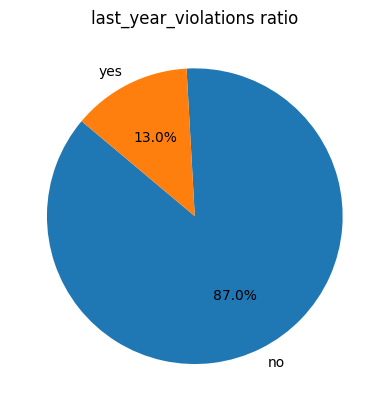

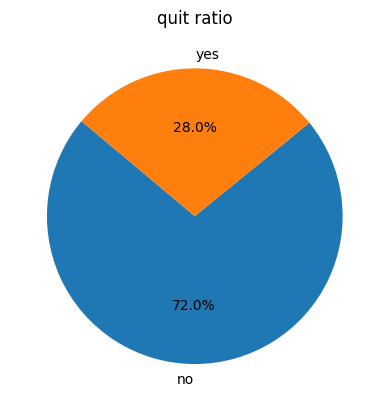

In [161]:
# Визуализация категориальных признаков и таргета тестовой  выборки
for cat in test_set_2[categoric(test_set_2)]:
    plot_pie_chart(test_set_2, cat)

- Распределения признаков в тренировочной и тестовой выборках имеют похожий характер.
- Соотношение категориальных признаков в тренировочной и тестовой выборках также имеют похожий характер.
- Однако , наблюдается **дисбаланс** классов таргета. 
- При оценке модели необходимо использовать метрики, которые лучше отражают производительность на несбалансированных данных, например **ROC-AUC**.

<function matplotlib.pyplot.show(close=None, block=None)>

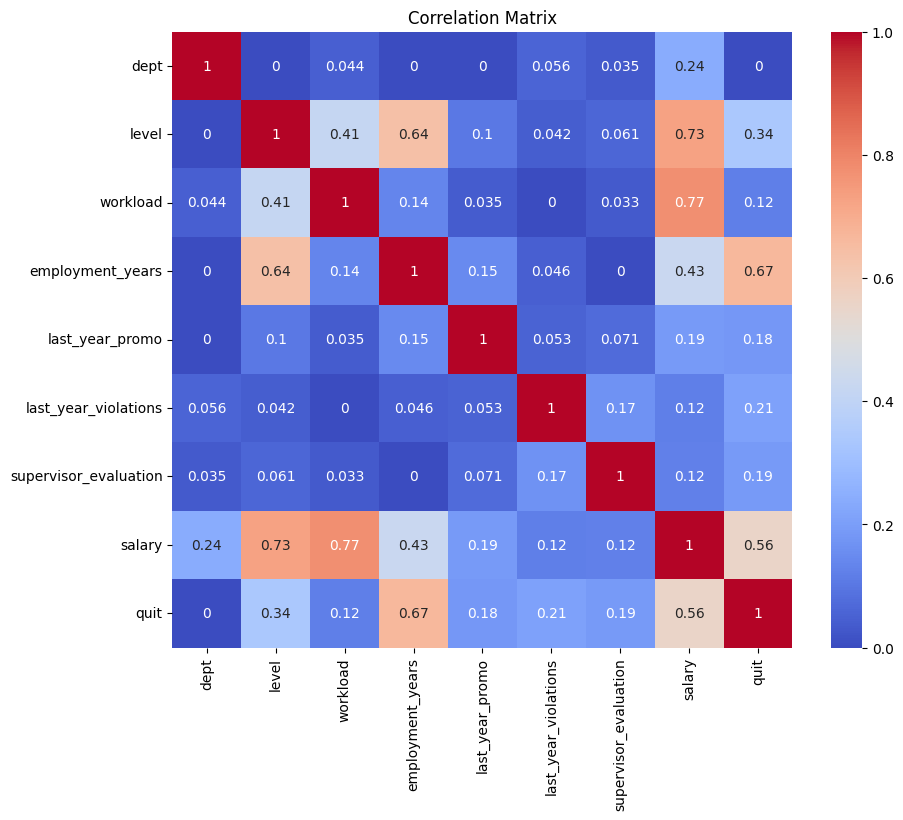

In [162]:
# Матрица корреляции
matrix = phik_matrix(train_set, interval_cols=['salary'])

plt.figure(figsize=[10,8])
sns.heatmap(matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show

- Мультиколлинеарности не обнаружено.
- Высокая корреляция таргета с 'employment_years' и умеренная c 'job_satisfaction_rate'.
- Отсутствует корреляция с признаков 'dept', что можно учесть при отборе признаков при моделировании.

**Оценка влияния признака "dept" на таргет методом ANOVA.**

H0: никаких статистически значимых различий между группами не существует (т.е. средние значения уволившихся сотрудников по департаментам равны между собой).

H1: по крайней мере, одно среднее значение группы отличается от других.

In [163]:
train_copy = train_set.copy()

# Кодирование таргета
le = LabelEncoder()
original_classes = ['yes', 'no']
le.classes = np.array(original_classes)
train_copy['quit'] = le.fit_transform(train_copy['quit'])

# Группировка данных по департаментам для ANOVA
grouped_data = [train_copy[train_copy['dept'] == dept]['quit'] for dept in train_copy['dept'].unique()]

# Проведение однофакторного дисперсионного анализа (ANOVA)
f_stat, p_value = f_oneway(*grouped_data)

print(f"F-статистика: {f_stat:.4f}")
print(f"P-значение: {p_value:.4f}")

# Интерпретация результата
alpha = 0.05
if p_value < alpha:
    print("Есть статистически значимые различия между средними значениями таргета для различных департаментов.")
else:
    print("Нет статистически значимых различий между средними значениями таргета для различных департаментов.")

F-статистика: 0.8861
P-значение: 0.4713
Нет статистически значимых различий между средними значениями таргета для различных департаментов.


- Не отвергаем нулевую гипотезу.

#### 2.2.2 Портрет уволившегося сотрудника

In [164]:
train_set.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


In [165]:
# Датасет с уволившимися сотрудниками
quit_yes = train_set.loc[train_set['quit']=='yes']

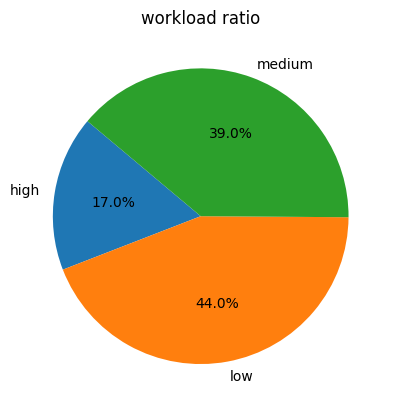

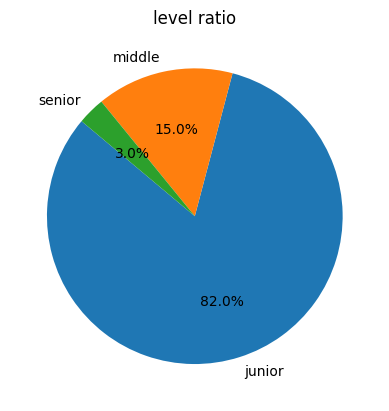

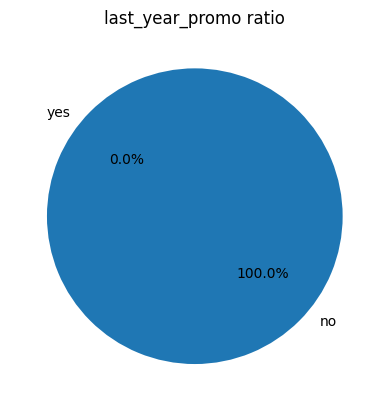

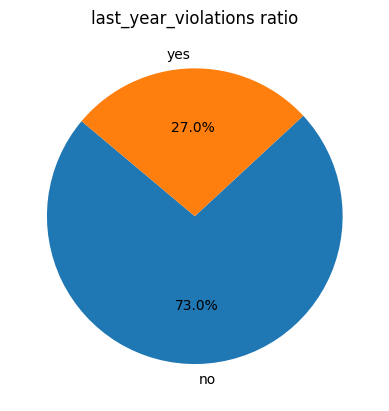

In [166]:
# Визуализация категориальных признаков без учёта отдела.
colls = ['workload', 'level', 'last_year_promo', 'last_year_violations']
for col in colls:
    plot_pie_chart(quit_yes, col)

In [167]:
# Срок работы уволившихся сотрудников 
quit_yes[['employment_years']].value_counts(normalize=True)

employment_years
1                  0.42
2                  0.27
3                  0.20
4                  0.04
5                  0.03
6                  0.02
7                  0.01
8                  0.00
9                  0.00
10                 0.00
Name: proportion, dtype: float64

In [168]:
# Оценка уволившихся сотрудников
quit_yes[['supervisor_evaluation']].value_counts(normalize=True)

supervisor_evaluation
3                       0.42
4                       0.23
2                       0.19
1                       0.11
5                       0.07
Name: proportion, dtype: float64

In [169]:
# Средняя зарплата, стаж, оценка уволившихся и оставшихся сотрудников
train_set.groupby(['quit'])[['salary', 'employment_years', 'supervisor_evaluation']].mean()

,salary,employment_years,supervisor_evaluation
quit,,,
no,"40,952.17",4.91,3.51
yes,"25,767.94",2.16,2.96


In [170]:
# Средняя зарплата по отделу
train_set.groupby('dept')[['salary']].mean()

,salary
dept,
hr,"35,448.28"
marketing,"37,446.81"
purchasing,"35,112.56"
sales,"35,584.10"
technology,"41,442.34"


**Портрет уволившегося сотрудника**

По результатам вышеприведённого исследования можно сделать вывод, что в основном, сотрудник, потенциально планирующий увольняться:
- Имеет уровень 'junior';
- Имеет небольшой объём работы;
- Имеет зарплату ниже средней по отделу;
- Работает в Компании менее 3-х лет;
- Не повышался в предыдущий год;
- Имеет относительно средние показатели работы (не превышающие 3).

#### 2.2.3 Влияние уровня удовлетворённости на увольнение

In [171]:
# Датасет с двумя целевыми признаками
satisfaction_quit = test_target.merge(test_target_2, on='id')
satisfaction_quit.head()

,id,job_satisfaction_rate,quit
0,130604,0.74,no
1,825977,0.75,no
2,418490,0.60,yes
3,555320,0.72,no
4,826430,0.08,yes


In [172]:
# Разделение на уволившихся и нет
satisfaction_quit_yes = satisfaction_quit[satisfaction_quit['quit']=='yes']
satisfaction_quit_no = satisfaction_quit[satisfaction_quit['quit']=='no']

In [173]:
# Статистические показатели
satisfaction_quit.groupby('quit')['job_satisfaction_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
quit,,,,,,,,
no,"1,436.00",0.61,0.20,0.03,0.50,0.66,0.76,1.00
yes,564.00,0.39,0.19,0.04,0.24,0.37,0.49,0.97


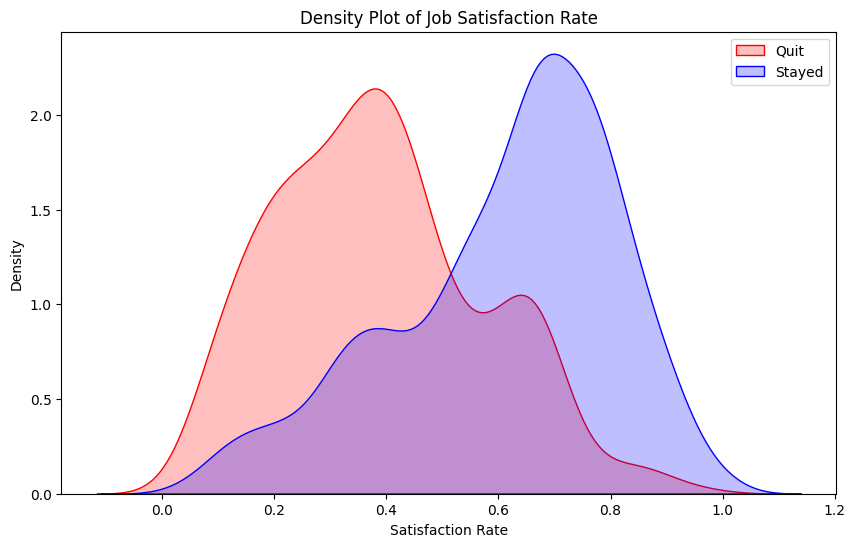

In [174]:
# Визуализация распределений 
plt.figure(figsize=(10, 6))

sns.kdeplot(satisfaction_quit_yes['job_satisfaction_rate'], shade=True, color="r", label="Quit")
sns.kdeplot(satisfaction_quit_no['job_satisfaction_rate'], shade=True, color="b", label="Stayed")

plt.title("Density Plot of Job Satisfaction Rate")
plt.xlabel("Satisfaction Rate")
plt.ylabel("Density")

plt.legend()
plt.show()

В целом, по представленным данным наблюдается, что для уволившихся сотрудников уровень удовлетворённости **ниже**:
- Средний показатель удовлетворённости: 0.39 (+-0.19) и (0.61+-0.2) для уволившихся и оставшихся соответственно.
- Медианные значения удовлетворённости: 0.37 и 0.66 для уволившихся и оставшихся соответственно.
- Максимальные значения удовлетворённости: 1 и 0.97 для уволившихся и оставшихся соответственно.

**Проверка влияния удовлетворённости на таргет методом Т-тест**

- Нулевая гипотеза (H0): средние уровни удовлетворённости у оставшихся и уволившихся сотрудников равны.
- Альтернативная гипотеза (Н1): средний уровень удовлетворённости оставшихся сотрудников выше.

In [175]:
# Проверка статистической значимости различий в удовлетворённости от работы
group1 = satisfaction_quit[satisfaction_quit['quit']=='no']['job_satisfaction_rate']
group2 = satisfaction_quit[satisfaction_quit['quit']=='yes']['job_satisfaction_rate']

results = ttest_ind(group1, group2, alternative='greater')

print(f"P-значение: {results.pvalue}") 

if results.pvalue < 0.05:
    print("Отвергаем нулевую гипотезу в пользу альтернативной.")
else:
    print("Нет оснований отвергать нулевую гипотезу.")

P-значение: 6.155610332585965e-105
Отвергаем нулевую гипотезу в пользу альтернативной.


Статистический тест также показывает, что удовлетворённость влияет на то, примет ли сотрудник решение уволиться.

### 2.3 Подготовка признаков и моделирование

- Добавление признака удовлетворённость от работы в выборки.

In [176]:
train_set['job_satisfaction_rate'] = model.predict(train_set)
train_set.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.64
814010,sales,junior,medium,2,no,no,4,27600,no,0.83
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.41
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.33
910140,marketing,junior,medium,2,no,no,5,25200,no,0.83


In [177]:
test_set_2['job_satisfaction_rate'] = model.predict(test_set_2)
test_set_2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,no,0.83
686555,hr,junior,medium,1,no,no,4,30000,no,0.67
467458,sales,middle,low,5,no,no,4,19200,no,0.66
418655,sales,middle,low,6,no,no,4,19200,no,0.66
789145,hr,middle,medium,5,no,no,5,40800,no,0.83


- Удираем признак "dept".

In [178]:
# Выборки

X_train = train_set.drop(['quit', 'dept'], axis=1)
y_train = train_set['quit']

X_test = test_set_2.drop(['quit', 'dept'], axis=1)
y_test = test_set_2['quit']

X_train.shape, X_test.shape

((2587, 8), (2000, 8))

In [179]:
# Кодирование таргета (1 - уволился, 0 - остался)
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [180]:
# Списки категориальных и числовых признаков

onehot_features = ['last_year_promo', 'last_year_violations']
ordinal_features = ['level', 'workload']
numerical_features = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

# Проверка, что все признаки учтены
assert len(onehot_features) + len(ordinal_features) + len(numerical_features) == X_train.shape[1], \
    'Не все признаки учтены.'

In [181]:
# Пайплайн для кодировки признаков без ранжирования

onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Пайплайн для подготовки признаков с ранжированием

ordinal_transformer = Pipeline(steps=[
    ('imputer_init', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['junior', 'middle', 'senior'],
                                           ['low', 'medium', 'high']],
                              handle_unknown='use_encoded_value',
                              unknown_value=-1)),
    ('imputer_final', SimpleImputer(missing_values=-1, strategy='most_frequent'))
])

# Пайплайн для подготовки числовых признаков

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Общий папйплайн для подготовки признаков

features_preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', onehot_transformer, onehot_features),
        ('ordinal', ordinal_transformer, ordinal_features),
        ('num', numeric_transformer, numerical_features)
    ],
    remainder='passthrough'
)

# Пайплайн, включающий подготовку данных и модель

quit_pipe = Pipeline(steps=[
    ('preprocessor', features_preprocessor),
    ('model', LogisticRegression(random_state=RANDOM_STATE))
])

In [182]:
# Параметрическая сетка для RandomizedSearch

param_grid = [
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': range(2, 6),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), 'passthrough']
    },
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': range(2,5),
        'model__min_samples_split': range(2,5),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), 'passthrough']
    },
    {
        'model': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'model__C': range(1, 5),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), 'passthrough']
    },
    {
        'model': [SVC(probability=True, random_state=RANDOM_STATE)],
        'model__C': range(1, 5),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), 'passthrough']
    }
]

In [183]:
# Запуск случайного поиска
random_search = RandomizedSearchCV(
    quit_pipe,
    param_distributions=param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [184]:
random_search.fit(X_train, y_train_encoded)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehot',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ordinal',
                                                                               Pipeline(s...
                                                               'passthrough']},
                                        {'model': [LogisticRegression(penalty='l1',
                                                                      random_state=0,
                                                                      solver='liblinear')],
                                         'model__C': range(1, 5),
                                         'preprocessor__num': [MinMaxScaler(),
                                                               StandardScaler(),
                                                               'passthrough']},
                                        {'model': [SVC(probability=True,
                                                       random_state=0)],
                                         'model__C': range(1, 5),
                                         'preprocessor__num': [MinMaxScaler(),
                                                               StandardScaler(),
                                                               'passthrough']}],
                   random_state=0, scoring='roc_auc')

In [185]:
# Параметры лучшей модели
random_search.best_params_

{'preprocessor__num': 'passthrough',
 'model__min_samples_split': 2,
 'model__max_depth': 4,
 'model': DecisionTreeClassifier(random_state=0)}

In [186]:
print(f'Метрика ROC-AUC на кросс-валидации: {random_search.best_score_}')

Метрика ROC-AUC на кросс-валидации: 0.9048186211670453


In [187]:
model = random_search.best_estimator_
y_pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc}')

Метрика ROC-AUC на тестовой выборке: 0.9152288419368221


В результате случайного поиска отобрана модель DecisionTreeClassifier со следующими параметрами:
- предобработка числовых признаков пропускается, данные передаются в модель без изменения,
- максимальная глубина дерева решений - 4 уровня,
- минимальное количество образцов для разделения узла - 2.
- метрика ROC-AUC = 0.92 на тестовой выборке, что соответствует ТЗ. 

In [188]:
# Проверка модели на адекватность
quit_pipe_dummy = Pipeline(steps=[
    ('preprocessor', features_preprocessor),
    ('model', DummyClassifier(random_state=RANDOM_STATE))
])

quit_pipe_dummy.fit(X_train, y_train_encoded)
y_pred_proba_dummy = quit_pipe_dummy.predict_proba(X_test)[:, 1]

roc_auc_dummy = roc_auc_score(y_test_encoded, y_pred_proba_dummy)
print(f'Метрика ROC-AUC DummyClassifier на тестовой выборке: {roc_auc_dummy}')

Метрика ROC-AUC DummyClassifier на тестовой выборке: 0.5


Метрика DummyClassifier хуже чем у выбранной модели.

Посмотрим, какие признаки модель считает наиболее важными.

In [189]:
X_train_transformed = quit_pipe.named_steps['preprocessor'].fit_transform(X_train)
X_test_transformed = quit_pipe.named_steps['preprocessor'].transform(X_test)

PermutationExplainer explainer: 2001it [00:23, 53.64it/s]                           


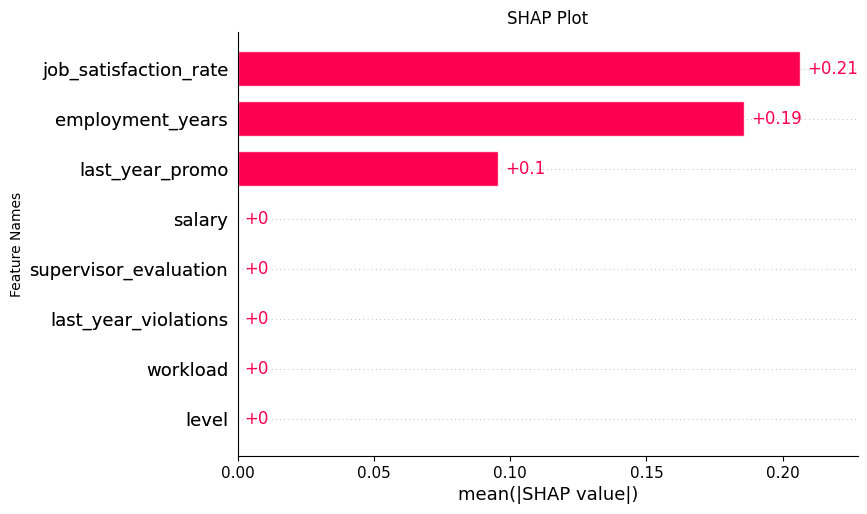

In [190]:
fig, ax = plt.gcf(), plt.gca()
ax.set_title("SHAP Plot")
ax.set_ylabel("Feature Names")

explainer = shap.PermutationExplainer(random_search.best_estimator_.named_steps['model'].predict_proba, X_test_transformed)
feature_names = X_train.columns.tolist()
explainer.feature_names = feature_names
shap_values_ = explainer(X_test_transformed)
shap.plots.bar(shap_values_[:,:,1], max_display=16)

plt.show()

Признаки, которые сильнее всего повлияют на то, уволится ли сотрудник: показатель удовлетворённости, уровень сотрудника, а также объём работы.

## 3. Выводы и рекомендации

**Общий вывод**
- В ходе работы над вышеприведённым проектом были решены задачи регрессии и классификации для прогнозирования уровня удовлетворённости сотрудников и ухода сотрудников из Компании. 

- В части предсказания уровня удовлетворённости, самое сильное влияние оказывает оценка за работу, также уровень должности, стаж и зарплата.

- В свою очередь уровень удовлетворённости очень сильно влияет на вероятность увольнения сотрудника, наряду с такими признаками как уровень должности и объём работы. 

**Рекомендации заказчику**
- Вероятно, следует уделять особое внимание оценке труда сотрудников, так как, очевидно, это воспринимается сотрудниками серьезно и сказывается на их удовлетворённости, что является ключевым фактором при увольнении сотрудников, поэтому важно максимально повысить удовлетворенность сотрудников их деятельностью. В этом случае отток кадров действительно может быть сокращен.

- Также, не смотря на то, что текучесть кадров является неизбежным явлением в бизнесе, возможно, стоит рассмотреть возможность внедрения дополнительных интересных инициатив для сотрудников на ранних этапах работы (1-2 года), такие как корпоративные мероприятия, социальные гарантии, премии и др.
